In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import matplotlib

In [2]:

def svd_decomposition(feature_space, feature):
   a = []
   for element in feature_space:
      a.append(element[feature])

   a_array = np.array(a)

   U, S, Vh = np.linalg.svd(a_array, full_matrices=False, compute_uv=True, hermitian=False)

   return U, S, Vh


def get_top_k_latent_features(U, k):
   return U[:, :k]


In [3]:
def plot_latent_features(S):
   S_list = S.tolist()

   top_k_list = [elem for elem in S_list if elem > 100000]

   plt.plot(S_list, marker='o')  # 'marker' aggiunge i punti ai valori
   plt.title('Andamento continuo dei dati')
   plt.xlabel('Indice')
   plt.ylabel('Valore')
   plt.grid(True)
   plt.show()


   print(top_k_list)
   print(len(top_k_list))

def find_elbow_point(y):

   x = np.arange(len(y))
   # Rette di riferimento: primo e ultimo punto
   line_vec = np.array([x[-1] - x[0], y[-1] - y[0]])
   line_vec = line_vec / np.linalg.norm(line_vec)

   # Distanza di ogni punto dalla retta
   vec_from_first = np.stack((x - x[0], y - y[0]), axis=1)
   scalar_proj = np.dot(vec_from_first, line_vec)
   proj = np.outer(scalar_proj, line_vec)
   vec_to_line = vec_from_first - proj
   dist_to_line = np.linalg.norm(vec_to_line, axis=1)

   # Trova l'indice con distanza massima
   elbow_idx = np.argmax(dist_to_line)

   return elbow_idx

In [4]:
def serialize_latent_space(feature_space, U, path="/workspaces/dbm25/data/svd_latent_features.pt"):
   latent_feature_list = U.tolist()

   old_feature_space = pd.DataFrame(feature_space)
   old_feature_space = old_feature_space[["file_path", "class"]]
   old_feature_space["svd_latent"] = latent_feature_list

   new_feature_space = []

   for index, elem in old_feature_space.iterrows():
      new_feature_space.append(elem.to_dict())

   torch.save(new_feature_space, f=path)

**Find top k latent features:**

In [5]:
feature_space = torch.load("/workspaces/dbm25/data/extracted_features.pt")
feature = "hog"

U, S, Vh = svd_decomposition(feature_space, feature)

# find the elbow point of the S values
elbow_idx = find_elbow_point(S)
print(f"Elbow point index: {elbow_idx}")
# extract the top k latent features based on the elbow point
k = elbow_idx
top_k_latent_features = get_top_k_latent_features(U, k)
serialize_latent_space(feature_space, top_k_latent_features, path=f"/workspaces/dbm25/data/top_{k}_svd_latent_features.pt")



Elbow point index: 42


**Find latent features weights**

In [6]:
def extract_latent_features_weight(latent_feature_space):
   weight_list = []
   for element in latent_feature_space:
      index_weight = [(f"Latent Feature {i}: ", weight) for i, weight in enumerate(element["svd_latent"])]
      #sorted_weights = np.sort(element["svd_latent"])[::-1]
      index_weight = sorted(index_weight, key=lambda x: x[1], reverse=True)
      
      image_id = element["file_path"].split("/").pop()
      new_pair = (image_id, index_weight)
      weight_list.append(new_pair)
   
   return weight_list

In [10]:
latent_feature_space = torch.load("/workspaces/dbm25/data/top_42_svd_latent_features.pt")

features_weight = extract_latent_features_weight(latent_feature_space)

print(features_weight[0])

('brain_glioma_0051.jpg', [('Latent Feature 10: ', 0.022267003272861612), ('Latent Feature 15: ', 0.01875058887792979), ('Latent Feature 6: ', 0.015898522651758732), ('Latent Feature 16: ', 0.010195627293968234), ('Latent Feature 1: ', 0.010154802233786685), ('Latent Feature 5: ', 0.009789932774280946), ('Latent Feature 2: ', 0.009678301061194597), ('Latent Feature 41: ', 0.009540022288083223), ('Latent Feature 22: ', 0.009383068584198141), ('Latent Feature 9: ', 0.00853590719862667), ('Latent Feature 4: ', 0.007789152347962323), ('Latent Feature 20: ', 0.006428312048047594), ('Latent Feature 28: ', 0.00522268341443051), ('Latent Feature 11: ', 0.005084568743750764), ('Latent Feature 40: ', 0.002762890218766984), ('Latent Feature 36: ', 0.002234729375821086), ('Latent Feature 37: ', 0.00192511862766276), ('Latent Feature 13: ', 0.0017734909009583125), ('Latent Feature 32: ', 0.0009282861818514585), ('Latent Feature 24: ', -0.0001231791866280247), ('Latent Feature 26: ', -0.000455264385

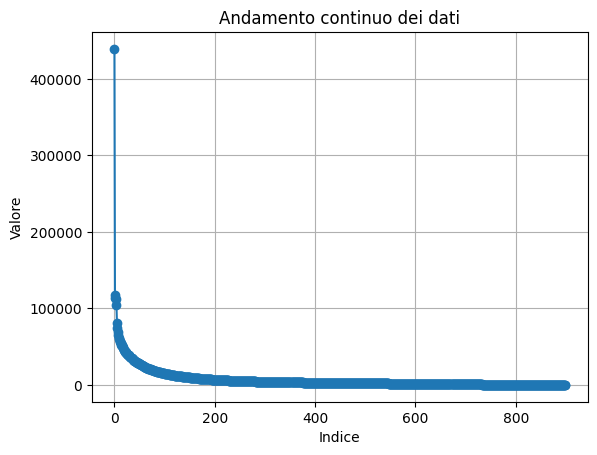

[439198.81782244635, 118162.86730212785, 113341.43523969062, 112689.58741115921, 104179.26201347548]
5


In [8]:
# Plotting the top k latent features with plot_latent_features
plot_latent_features(S)